In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coradata/cora/cora.cites
/kaggle/input/coradata/cora/readme.html
/kaggle/input/coradata/cora/README
/kaggle/input/coradata/cora/cora.edges
/kaggle/input/coradata/cora/cora.node_labels
/kaggle/input/coradata/cora/cora.content


In [2]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-clzaycwa
  Created wheel for spektral: filename=spektral-0.6.2-py3-none-any.whl size=95318 sha256=946689d31d51cbf15a9f39b36ebb91b10ef55ade87c168322c74192c1c76c831
  Stored in directory: /tmp/pip-ephem-wheel-cache-sx9vvf7x/wheels/af/7c/1f/e06aba9c0f493bb708968b8b396fe7523fdfb1c1c0818730be
Successfully built spektral


In [6]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:

from sklearn.utils import shuffle
all_data = []
all_edges = []

for root,dirs,files in os.walk('../input/coradata'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

In [8]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)

In [9]:
X.shape

(2708, 1433)

In [10]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Genetic_Algorithms', 'Case_Based', 'Theory'}

Number of classes:  7


In [11]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [12]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [13]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [14]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [15]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


In [16]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [17]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [18]:
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout[0][0]                    
                                                                 input_2[0][0]         

In [19]:
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 1s 792ms/step - loss: 0.1156 - acc: 0.1357 - val_loss: 0.3626 - val_acc: 0.3100
Epoch 2/200
1/1 [==============================] - 0s 65ms/step - loss: 0.1081 - acc: 0.4429 - val_loss: 0.3505 - val_acc: 0.4160
Epoch 3/200
1/1 [==============================] - 0s 66ms/step - loss: 0.1004 - acc: 0.5714 - val_loss: 0.3366 - val_acc: 0.5740
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0937 - acc: 0.7071 - val_loss: 0.3230 - val_acc: 0.6360
Epoch 5/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0869 - acc: 0.7714 - val_loss: 0.3111 - val_acc: 0.6500
Epoch 6/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0848 - acc: 0.7714 - val_loss: 0.3009 - val_acc: 0.6700
Epoch 7/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0819 - acc: 0.7929 - val_loss: 0.2911 - val_acc: 0.7100
Epoch 8/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0776 - acc: 0.8

In [20]:
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.66      0.81      0.73       114
    Genetic_Algorithms       0.87      0.85      0.86       156
       Neural_Networks       0.81      0.72      0.76       290
 Probabilistic_Methods       0.78      0.70      0.74       172
Reinforcement_Learning       0.71      0.82      0.76        85
         Rule_Learning       0.59      0.78      0.67        60
                Theory       0.65      0.62      0.63       123

              accuracy                           0.75      1000
             macro avg       0.72      0.76      0.74      1000
          weighted avg       0.75      0.75      0.75      1000



In [21]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3])

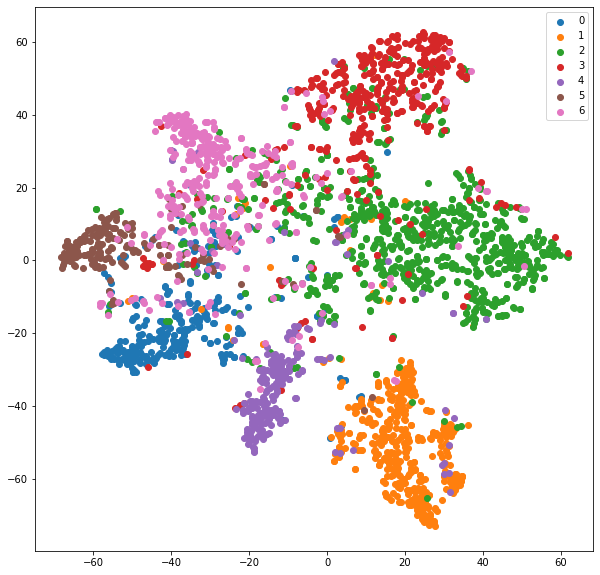

In [22]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

comparison to fully connected neural net

In [23]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 466ms/step - loss: 0.2186 - acc: 0.1786 - val_loss: 0.4365 - val_acc: 0.2140
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1761 - acc: 0.3071 - val_loss: 0.4040 - val_acc: 0.2800
Epoch 3/200
1/1 [==============================] - 0s 43ms/step - loss: 0.1410 - acc: 0.5143 - val_loss: 0.3719 - val_acc: 0.4520
Epoch 4/200
1/1 [==============================] - 0s 69ms/step - loss: 0.1116 - acc: 0.6857 - val_loss: 0.3391 - val_acc: 0.5360
Epoch 5/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0882 - acc: 0.7714 - val_loss: 0.3046 - val_acc: 0.5800
Epoch 6/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0665 - acc: 0.8714 - val_loss: 0.2820 - val_acc: 0.5640
Epoch 7/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0520 - acc: 0.9286 - val_loss: 0.2694 - val_acc: 0.5700
Epoch 8/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0446 - acc: 0.9

In [24]:
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.55      0.53      0.54       114
    Genetic_Algorithms       0.67      0.81      0.73       156
       Neural_Networks       0.72      0.53      0.61       290
 Probabilistic_Methods       0.75      0.49      0.59       172
Reinforcement_Learning       0.46      0.61      0.53        85
         Rule_Learning       0.35      0.70      0.46        60
                Theory       0.42      0.48      0.45       123

              accuracy                           0.58      1000
             macro avg       0.56      0.59      0.56      1000
          weighted avg       0.62      0.58      0.58      1000



In [25]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

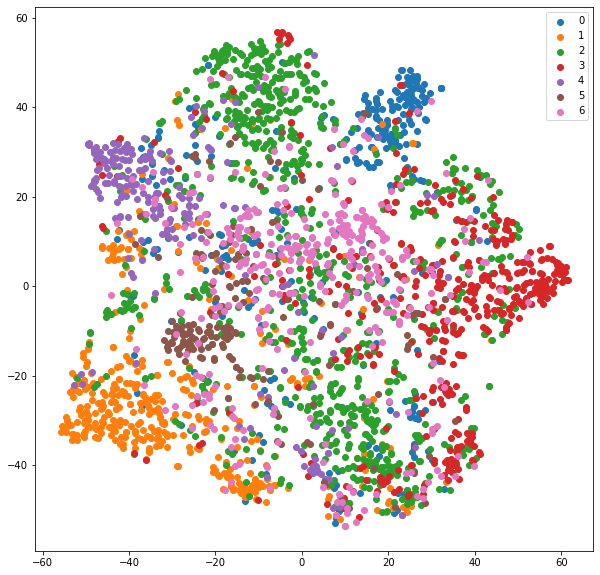

In [26]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)